In [1]:
""" 
*** Functions for tiling ***
"""
import math
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

# p = (RA, DEC)
def Equi2Cart(p):
    alpha = np.radians(p[0])
    delta = np.radians(p[1])
    x = np.cos(alpha) * np.cos(delta)
    y = np.sin(alpha) * np.cos(delta)
    z = np.sin(delta)
    return [x, y, z]
    # returns a vector in cartesian

# v = [x, y, z]
def Cart2Equi(v):
    x, y, z = v[0], v[1], v[2]
    ra = np.rad2deg(math.atan2(y,x))
    dec = np.rad2deg(math.asin(z))
    return [ra, dec]
    # returns a point in equitorial

# rotate about tile center
def rotate(angle):
    theta = np.radians(angle)
    Rx = [[1, 0, 0],
          [0, np.cos(theta), -np.sin(theta)],
          [0, np.sin(theta), np.cos(theta)]]
    return Rx

# move the center of the tile to the desired equatorial coordinates
def move(RA, DEC):
    alpha = np.radians(RA)
    delta = np.radians(DEC)
    # move to DEC coordinate
    Ry = [[np.cos(delta), 0, -np.sin(delta)],
          [0, 1, 0],
          [np.sin(delta), 0, np.cos(delta)]]
    # move to RA coordinate
    Rz = [[np.cos(alpha), -np.sin(alpha), 0],
          [np.sin(alpha), np.cos(alpha), 0],
          [0, 0, 1]]
    return np.matmul(Rz, Ry)

# coordinates of each CCD of the tile = [CCD1, CCD2, CCD3, CCD4]
def CCD_array(l=900/3600, w=860/3600, g=26/3600):
    RA = {1: g/2 + l, 2: g/2 + l, 3: g/2, 4: g/2, 5: g/2 + l, 6: g/2 + l, 7: g/2, 8: g/2, 
          9: -g/2, 10: -g/2, 11: -(g/2 + l), 12: -(g/2 + l), 13: -g/2, 14: -g/2, 15: -(g/2 + l), 16: -(g/2 + l)}
    DEC = {1: -(g/2 + w), 2: -g/2, 3: -g/2, 4: -(g/2 + w), 5: g/2, 6: g/2 + w, 7: g/2 + w, 8: g/2,
           9: g/2, 10: g/2 + w, 11: g/2 + w, 12: g/2, 13: -(g/2 + w), 14: -g/2, 15: -g/2, 16: -(g/2 + w)}
    tile = [[] for _ in range(4)]
    for i in range(1, 17):
        tile[(i - 1) // 4].append(Equi2Cart((RA[i],DEC[i])))
    return tile

# the projected length at a given declination 
def ProjDec(length, DEC):
    p = [length, 0]
    pp = Cart2Equi(np.matmul(move(0, DEC), Equi2Cart(p)))
    return pp[0]

# returns a tile multipolygon, the intersection ratio between the tile and footprint
def per_tile(footprint, RA, DEC, angle=0, l=900/3600, w=860/3600, g=26/3600):
    CCDs = []
    tile = CCD_array(l, w, g)
    inter_area = 0
    for CCD in tile:
        ra = []
        dec = []
        for i in range(4):
            # CCD[i] = (x, y, z) of each vertex of the CCD 
            CCD[i] = np.matmul(rotate(angle), CCD[i])
            CCD[i] = np.matmul(move(RA, DEC), CCD[i])
            x, y, z = CCD[i][0], CCD[i][1], CCD[i][2]
            # cartesian to equatorial 
            ra.append(np.rad2deg(math.atan2(y,x)))
            dec.append(np.rad2deg(math.asin(z)))
        ra.append(ra[0])
        dec.append(dec[0])
        # create polygon for each CCD in the CCD_array
        vertices = [(x, y) for x, y in zip(ra, dec)]
        polygon = Polygon(vertices)
        # each CCD's intersection with the footprint
        CCD_footprint = polygon.intersection(footprint)
        inter_area += CCD_footprint.area
        CCDs.append(polygon)
    # each tile is a multipolygon
    mp = MultiPolygon(CCDs)
    tile_area = mp.area  # each tile's area
    intersect_ratio = inter_area / tile_area
    return mp, intersect_ratio


In [2]:
""" 
*** Vertical snake scan *** 
"""

def VerticalTiling(survey_name, coords, min_intersect_ratio, tile_overlap=30/3600, l=900/3600, w=860/3600, g=26/3600):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.plot(coords[:, 0], coords[:, 1], linewidth=0.8, color='black', label="footprint boundary")
    
    footprint = Polygon(coords)
    xmin, ymin, xmax, ymax = footprint.bounds
    
    # avoid computing tiles at the [-180, 180] boundary
    if xmin < -179.9:
        xmin = -179.9
    if xmax > 179.9:
        xmax = 179.9
    
    slew_length = (2*l + g) - tile_overlap
    slew_width = (2*w + g) - tile_overlap
    DECvals = np.arange(ymin+w, ymax+w, step=slew_width)
    
    # collect valid tile center coords in tiling sequence
    tile_centers = [] 
    RAvals = []
    max_length = 0 
    
    for DEC in DECvals:
        # calculate the RAs for a given DEC
        RArow = np.arange(xmin + ProjDec(l, DEC), xmax + ProjDec(l, DEC), step=ProjDec(slew_length, DEC))
        max_length = max(max_length, len(RArow))
        RAvals.append(RArow)
    
    # add NaN to make each row the same length
    for i in range(len(RAvals)):
        diff = max_length - len(RAvals[i])
        if diff > 0:
            RAvals[i] = np.append(RAvals[i], [math.nan]*diff)
    
    # transpose the tiling sequence from 'by rows' to 'by columns'
    RAvals = np.array(RAvals).T
    
    for n, RAcolumn in enumerate(RAvals):
        column = []
        for (RA, DEC) in zip(RAcolumn, DECvals):
            if np.isnan(RA) == False:
                tile_obj, intersect_ratio = per_tile(footprint, RA, DEC)
                if intersect_ratio >= min_intersect_ratio:
                    column.append((RA, DEC))
                    for geom in tile_obj.geoms:
                        xs, ys = geom.exterior.xy
                        ax.fill(xs, ys, alpha=0.5, color='mediumturquoise', ec=None)
        # snake scan
        if n % 2 != 0:
            column = column[::-1]
        tile_centers.append(column)
    
    tile_centers = [j for i in tile_centers for j in i]
    tile_num = len(tile_centers)
    ax.plot(*zip(*tile_centers), linewidth=0.8, color='tab:red')
    ax.scatter(*zip(*tile_centers), s=5, color='black')
    ax.set_xlabel('RA (deg)', fontsize=9)
    ax.set_ylabel('DEC (deg)', fontsize=9)
    plt.title(f'{survey_name}', fontsize=12)
    fig.tight_layout()
    # plt.savefig(f'{survey_name}.pdf')
    
    return tile_centers

In [3]:
"""
*** Functions for tracking time and observing efficiency ***
"""

# find the angle (in degrees) between two points in equatorial coordinates (in deg)
def Haversine(p1, p2):
    ra1, dec1 = np.radians(p1[0]), np.radians(p1[1])
    ra2, dec2 = np.radians(p2[0]), np.radians(p2[1])
    theta12 = 2 * np.arcsin(np.sqrt(np.sin((dec2-dec1)/2)**2 + np.cos(dec1)*np.cos(dec2)*np.sin((ra2-ra1)/2)**2))
    return np.rad2deg(theta12)

# find the time it takes to slew a certain angle
def Angle2Time(theta):
    # Paul's Slew Angle vs. Slew Duration data
    slew_angle = np.array([0, 0.5, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 90, 90])
    slew_duration = np.array([30, 30, 66, 102, 138, 168, 198, 240, 276, 306, 336, 366, 414, 468])
    # linear interpolation --> interpolate slew time given the slew angle
    slew_time = np.interp(theta, slew_angle, slew_duration)
    return slew_time

# convert time in seconds to day, hour, minutes, seconds
def Seconds2Day(time):
    day = time // (24 * 3600)
    time = time % (24 * 3600)
    hour = time // 3600
    time %= 3600
    minutes = time // 60
    time %= 60
    seconds = time
    return day, hour, minutes, seconds

# Convert time elapsed in an orbit (sec.) --> telescope's position (degrees) around the Earth
# Angle theta starts in the East (viewed facing sun) going CCW; always between 0° to 360°
def Position(orbitTimeTrack):
    period = 100.9 # min
    # orbitTimeTrack is time elapsed from startAngle 
    theta = (orbitTimeTrack/60/period)*360 # degrees
    return theta

# the time passed (in sec.) while the telescope moves a given angle in the orbit
def PassedTime(angle):
    period = 100.9 # min
    return (angle/360)*period*60

import math
# Viewing angle as a function of theta_b (in deg)
# theta_b: boresight angle as measured from CVZ center (angle away from CVZ center)
def ViewingFrac(theta_b):
    # Earth radius
    Re = 6378*1000 # m
    # satellite orbit altitude
    h = 800*1000 # m
    # Earth limb angle
    rho = math.degrees(math.asin(Re/(Re+h))) # deg
    # Earth exclusion angle
    epsilon = 10 # deg    
    # nu: satellite orbit position angle, measured from the X-axis
    # delta_nu: viewing angle (rad); symmetrical about the Y-axis
    if 0 <= theta_b <= 90-rho-epsilon:
        frac = 1
    else:
        delta_nu = math.pi + 2*math.asin(math.cos(math.radians(rho+epsilon)) / math.sin(math.radians(theta_b)))
        frac = math.degrees(delta_nu) / 360
    return frac

# With 0° at positive RA (x-axis) direciton, going CCW
# satellite position = (x0, y0) where y0 = -7.8
# target = tile_center coords (x, y)
def ViewingZone(x0, target):
    y0 = -7.8
    x, y = target[0], target[1]
    xp = x - x0
    yp = y - y0
    # the direction where the boresight is pointing 
    theta = math.degrees(math.atan2(yp, xp))
    theta = (theta + 360) % 360
    # the angular distance the pointing is away from CVZ
    theta_b = math.sqrt(xp**2 + yp**2)
    frac = ViewingFrac(theta_b)
    halfVisAngle = frac*180 # degrees
    zone = [(theta-halfVisAngle+360)%360, (theta+halfVisAngle+360)%360]
    return zone


In [9]:
"""
*** CADENCE SURVEY ***
"""

# input the vertices (in equitorial coords) of the un-projected footprint shape 
# choose which survey is getting projected
def Project(footprint, survey_center):
    RA, DEC = survey_center[0], survey_center[1]
    proj_footprint = []
    for vertex in footprint:
        proj_vertex = Cart2Equi(np.matmul(move(RA, DEC), Equi2Cart(vertex)))
        proj_footprint.append(proj_vertex)
    return np.array(proj_footprint)

""" Cadence Survey has exposure time of 100s per tile """
def CadenceObserving(footprint, survey_name, survey_center, min_intersect_ratio, exposure, settle=90):
    tile_sequence = []
    # place_holder = [dead_time (s), telescope position range] 
    place_holder = [] # telescope position range = [start (deg), end (deg)]
    
    """ Data Info """
    onboard_data = 0 #GB
    px_amount = 8600 * 9000 * 4 * 3 #pixels
    byte_per_px = 2 #bytes
    data = (px_amount * byte_per_px)/10**9 #GB
    
    """ Tracker """
    # all time are in seconds
    Exposure = 0
    Overhead = 0
    Deadtime = 0
    ElapsedTime = 0
    
    """ Info Per Day (Visit) """
    # exposure time
    ExpoPerDay = []
    # overhead
    OverPerDay = []
    # dead time
    DeadPerDay = []
    # efficiency = Exposure / ElapsedTime
    EffPerDay = []
    # place holder
    PlaceHolderPerDay = {}

    proj_footprint = Project(footprint, survey_center)
    tile_centers = VerticalTiling(survey_name, proj_footprint, min_intersect_ratio)
    print(f'Survey consists of {len(tile_centers)} tiles')
    # tile index
    index = 0
    # number of visits
    visit = 0
    
    """ Satellite Position """
    daily_step = 360/365 # CVZ center movement across RA per day
    minRA = survey_center[0] - 90*daily_step
    maxRA = survey_center[0] + 90*daily_step
    sat_position = np.arange(minRA, maxRA, daily_step)
    print(f'Image once per day, for {len(sat_position)} days')
    print()
    
    # Each day
    for x0 in sat_position:
        visit += 1
        print(f'\033[1mvisit {visit}\033[0m')
        print(f"Satellite's RA = {x0}°")
        tiles = tile_centers[::-1] # copy the tiles in reverse order so target can be popped from the back
    
        # Assume that for each visit, the telescope is already at the startzone of the first tile
        zone = ViewingZone(x0, tiles[-1])
        startAngle = zone[0]+0.000001
        
        # Loop through all the tiles 
        while tiles:
            index += 1
            target = tiles.pop()
            
            theta = (Position(ElapsedTime) + startAngle) % 360
            #print(f'telescope position = {round(theta,4)}°')
    
            # Find the tile's viewing zone based on the satellite RA position 
            zone = ViewingZone(x0, target)
            startzone, endzone = zone[0], zone[1]
            # three types of viewing zone
            if endzone-startzone > 10**-8:
                # the viewing zone is continuous, where startzone < endzone
                scenario = 1
                #print(f"\033[1mtile {index}'s viewing zone: [{round(startzone,4)}°, {round(endzone,4)}°] \033[0m")
            elif round(startzone,7) == round(endzone,7):
                # the tile is in CVZ
                scenario = 2
                #print(f"\033[1mtile {index}'s viewing zone: [{round(startzone,4)}°, {round(endzone,4)}°] \033[0m")
            else:
                # the viewing zone wraps around from 360° to 0° 
                scenario = 3
                #print(f"\033[1mtile {index}'s viewing zone: [{round(startzone,4)}°, 360°] [0°, {round(endzone,4)}°] \033[0m")
            
            # In viewing zone
            if (scenario==1 and startzone<=theta<=endzone) or scenario==2 or (scenario==3 and (startzone<=theta<=360 or 0<=theta<=endzone)):
                # Calculate how much time is left in this viewing cycle
                if scenario==1:
                    time_available = PassedTime(endzone-theta)
                elif scenario==2:
                    time_available = PassedTime(endzone)
                else:
                    if endzone > theta:
                        time_available = PassedTime(endzone-theta)
                    else:
                        time_available = PassedTime(360-theta+endzone)

                time_used = 0
                if index != 1:
                    angle = Haversine(tile_sequence[-1], target)
                    slew = Angle2Time(angle)
                    time_used = slew + settle
                time_left = time_available - time_used
                #print(f'time left in this viewing cycle: {round(time_left,4)}s')
                
                # Enough time -> image the tile
                if time_left >= exposure:
                    # Slew to the tile
                    if index != 1:
                        #print('slew + settle takes', slew + settle, 's')
                        Overhead += slew + settle
                        ElapsedTime += slew + settle
                    # Fully image the tile
                    #print(f'Image tile {index}')
                    tile_sequence.append(target)
                    Exposure += exposure
                    ElapsedTime += exposure
                    onboard_data += data
                # Not enough time -> deadtime
                else:
                    tiles.append(target)
                    index -= 1
                    if scenario == 1:
                        dead_time = PassedTime(360-theta+startzone+0.0001) # in seconds
                    else:
                        if startzone > theta: 
                            dead_time = PassedTime(startzone-theta+0.0001)
                        else:
                            dead_time = PassedTime(360-theta+startzone+0.0001)
                    place_holder.append([dead_time, [theta, startzone+0.0001]])
                    #print('\033[1mdeadtime :\033[0m', place_holder[-1])
                    Deadtime += dead_time
                    ElapsedTime += dead_time
                    continue 
            # Not in viewing zone -> deadtime
            else:
                # could happen if the previous tile is in CVZ but the current tile is not
                print('Not in viewing zone')
                tiles.append(target)
                index -= 1
                if startzone > theta:
                    dead_time = PassedTime(startzone-theta+0.0001)
                else:
                    dead_time = PassedTime(360-theta+startzone+0.0001)
                place_holder.append([dead_time, [theta, startzone+0.0001]])
                print('\033[1mdeadtime :\033[0m', place_holder[-1])
                Deadtime += dead_time
                ElapsedTime += dead_time
            #print()
        
        # After all tiles are completed
        print('========================================================')
        print('\033[1mTotal Elapsed Time = exposure + overhead + deadtime')
        time = Seconds2Day(ElapsedTime)
        print(f'{time[0]} day, {time[1]} hr, {time[2]} min, {time[3]} sec \033[0m')
        print('Exposure:')
        time = Seconds2Day(Exposure)
        print(f'{time[0]} day, {time[1]} hr, {time[2]} min, {time[3]} sec')
        print('Overhead:')
        time = Seconds2Day(Overhead)
        print(f'{time[0]} day, {time[1]} hr, {time[2]} min, {time[3]} sec')
        print('Deadtime:')
        time = Seconds2Day(Deadtime)
        print(f'{time[0]} day, {time[1]} hr, {time[2]} min, {time[3]} sec')
        
        Efficiency = (Exposure / ElapsedTime)*100
        print(f'\033[1mObserving Efficiency: {round(Efficiency,2)}% \033[0m')
        print(f'Data accumulated: {round(onboard_data,2)} GB')
        print('========================================================')
        print()
    
        ExpoPerDay.append(Exposure)
        OverPerDay.append(Overhead)
        DeadPerDay.append(Deadtime)
        EffPerDay.append(Efficiency)
        PlaceHolderPerDay[visit] = place_holder
    
        Exposure = 0
        Overhead = 0
        Deadtime = 0
        place_holder = []
        
        index = 0
        ElapsedTime = 0
        theta = startAngle

    return ExpoPerDay, OverPerDay, DeadPerDay, EffPerDay, PlaceHolderPerDay, onboard_data


In [14]:
""" 
*** Survey Coordinates ***
"""

from shapely.geometry import Polygon
import numpy as np

# Coordinates Conversions
def RAdeg(hr, min, sec):
    degrees = (hr + min/60 + sec/3600) * 15
    return degrees
def DECdeg(deg, arcmin, arcsec):
    degrees = deg + arcmin/60 + arcsec/60
    return degrees

# Normalize RA values to the range [-180, 180] degrees.
def normalize_ra(ra):
    while ra >= 180:
        ra -= 360
    while ra < -180:
        ra += 360
    return ra

# The center coordinates of the four LSST Deep Drilling Fields
ELAIS_S1 = [RAdeg(0,37,48), DECdeg(-44,0,0)]
XMM_LSS = [RAdeg(2,22,50), DECdeg(-4,45,0)]
Chandra = [RAdeg(3,32,30), DECdeg(-28,6,0)]
COSMOS = [RAdeg(10,0,24), DECdeg(2,10,55)]

Survey consists of 45 tiles
Image once per day, for 180 days

visit 1
Satellite's RA = -79.31712328767122°
Total Elapsed Time = exposure + overhead + deadtime
0.0 day, 4.0 hr, 6.0 min, 26.187226725362052 sec 
Exposure:
0 day, 1 hr, 15 min, 0 sec
Overhead:
0.0 day, 1.0 hr, 28.0 min, 8.625207844866964 sec
Deadtime:
0.0 day, 1.0 hr, 23.0 min, 17.56201888049509 sec
Observing Efficiency: 30.43% 
Data accumulated: 83.59 GB

visit 2
Satellite's RA = -78.33082191780821°
Total Elapsed Time = exposure + overhead + deadtime
0.0 day, 4.0 hr, 6.0 min, 26.810901784554517 sec 
Exposure:
0 day, 1 hr, 15 min, 0 sec
Overhead:
0.0 day, 1.0 hr, 28.0 min, 8.625207844866964 sec
Deadtime:
0.0 day, 1.0 hr, 23.0 min, 18.185693939686644 sec
Observing Efficiency: 30.43% 
Data accumulated: 167.18 GB

visit 3
Satellite's RA = -77.3445205479452°
Total Elapsed Time = exposure + overhead + deadtime
0.0 day, 4.0 hr, 6.0 min, 27.439820003190107 sec 
Exposure:
0 day, 1 hr, 15 min, 0 sec
Overhead:
0.0 day, 1.0 hr, 28.0 m

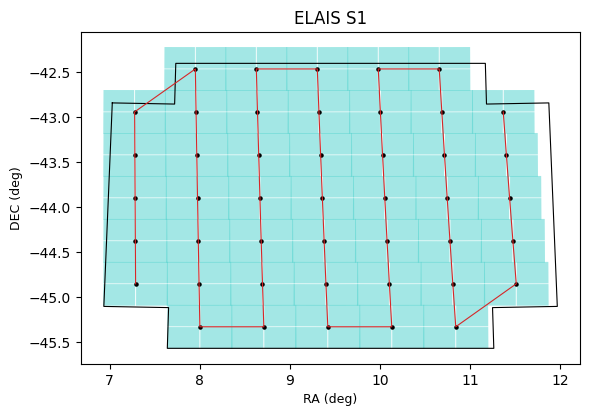

In [15]:
# LSST Deep Drilling Fields
# the footprint when centered at RA = 0 and DEC = 0 
footprint = np.loadtxt('LSST-DDF.txt')
""" choose survey """
survey_name = 'ELAIS S1'
survey_center = ELAIS_S1
# choose the min. required intersection between the tile and the footprint 
min_intersect_ratio = 0.3

ExpoPerDay, OverPerDay, DeadPerDay, EffPerDay, PlaceHolderPerDay, onboard_data = CadenceObserving(footprint, survey_name, survey_center, min_intersect_ratio, exposure=100)

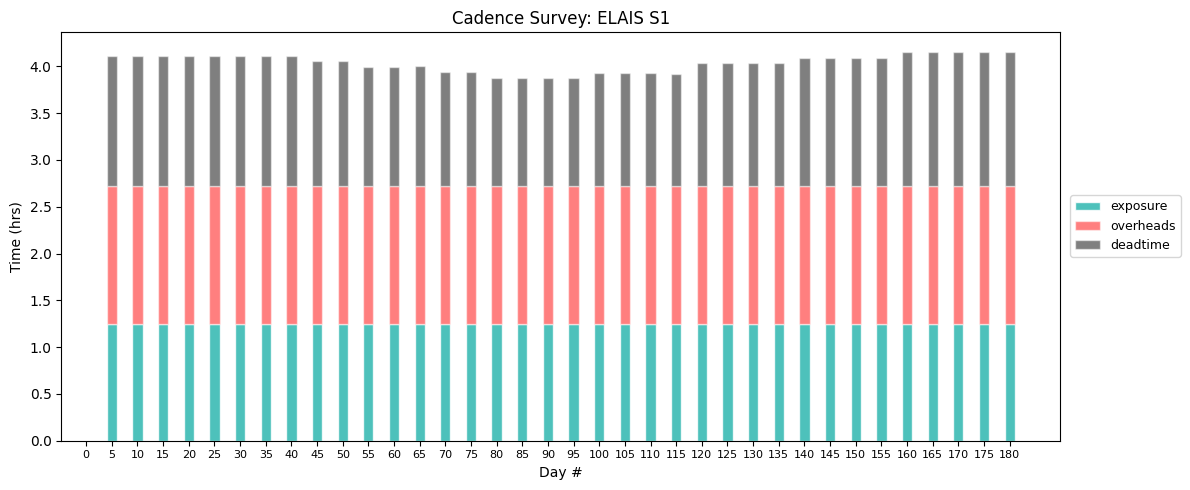

In [16]:
import matplotlib.pyplot as plt

# Plot the bar chart for every 5 days
interval = 5
Day = np.arange(1,181)[interval-1::interval]

exposure_hr = np.array(ExpoPerDay[interval-1::interval])/3600
overhead_hr = np.array(OverPerDay[interval-1::interval])/3600
deadtime_hr = np.array(DeadPerDay[interval-1::interval])/3600

fig = plt.figure(figsize = (12, 5))
bars1 = plt.bar(Day, exposure_hr, width=2, alpha=0.8, color='lightseagreen', edgecolor='white', label='exposure')
bars2 = plt.bar(Day, overhead_hr, bottom=exposure_hr, width=2, alpha=0.5, color='r', edgecolor='white', label='overheads')
bars3 = plt.bar(Day, deadtime_hr, bottom=exposure_hr+overhead_hr, width=2, alpha=0.5, color='k', edgecolor='white', label='deadtime')

plt.xlabel('Day #', fontsize=10)
plt.xticks(np.arange(0,180+interval,interval), fontsize=8)
plt.ylabel('Time (hrs)', fontsize=10)
plt.title(f'Cadence Survey: {survey_name}')
plt.legend(fontsize=9, loc=(1.01,0.45))
fig.tight_layout()
plt.savefig(f'eff {survey_name}.pdf')


In [8]:
avg_efficiency = np.mean(EffPerDay)
print('Average observing efficiency throughout 180 days:')
print(avg_efficiency,'%')

Average observing efficiency throughout 180 days:
34.59235383036354 %
